In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import findspark
findspark.init()

In [8]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix


spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

### Read File

In [9]:
df_raw=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("/content/sample_data/src.csv")

df = df_raw

In [10]:
df.show(2)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
+---+-----

### check DataType

In [11]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



### Statistics

In [12]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.279248836465,0,4918
campaign,41188,2.567592502670681,2.77001354290232,1,56
pdays,41188,962.4754540157328,186.91090734474088,0,999
previous,41188,0.17296299893172767,0.49490107983929005,0,7


### Numerical Features - Analysis

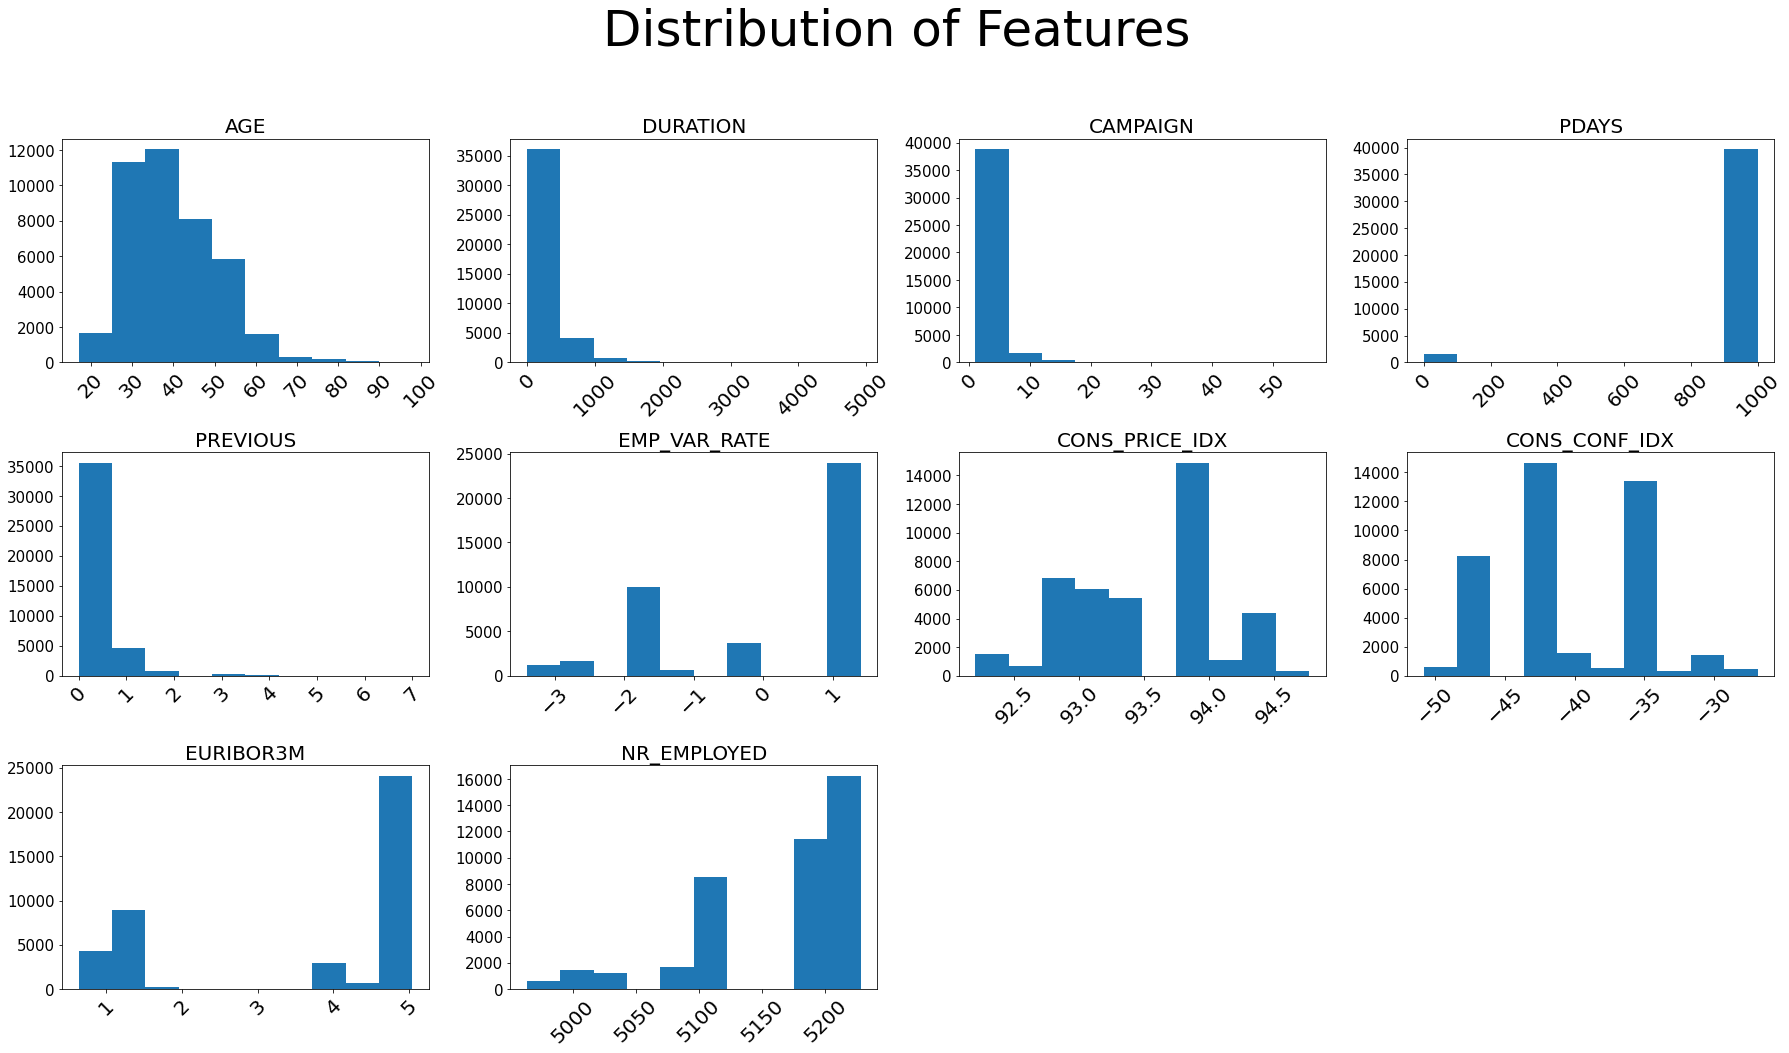

In [13]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    # plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

### Categorical Features - Analysis

In [14]:
df.groupBy('job').count().show()
df.groupBy('marital').count().show()
df.groupBy('education').count().show()
df.groupBy('default').count().show()
df.groupBy('housing').count().show()
df.groupBy('loan').count().show()
df.groupBy('contact').count().show()
df.groupBy('month').count().show()
df.groupBy('day_of_week').count().show()
df.groupBy('poutcome').count().show()
df.groupBy('y').count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+

+-------+-----+
|default|count|
+-------+-----+
|unknown| 8597|
|     no|32588|
|    yes|    3|
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|unknown|  9

### Check for null values

In [15]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull() | (col(c) == '' ), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Correlation

In [16]:
# numeric_features

numeric_features_p = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features_p)

In [17]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


### Dropping columns with high correlation - cons_price_idx, euribor3m , nr_employed , emp _var_rate

In [18]:
df=df.drop("cons_price_idx","euribor3m","nr_employed","emp_var_rate")

df.show(2)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+-------------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|cons_conf_idx|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+-------------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|        -36.4| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|        -36.4| no|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+-------------+---+
only showing top 2 rows



### Creating new column age group

In [19]:
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

In [20]:
df.toPandas()
df.show(2)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+-------------+---+-------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|cons_conf_idx|  y|Age_udf|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+-------------+---+-------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|        -36.4| no|Over 50|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|        -36.4| no|Over 50|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+-------------+---+-------+
only showing top 2 rows



### StringIndexer

In [21]:
# age
stringIndexer = StringIndexer()\
                 .setInputCol ("Age_udf")\
                 .setOutputCol ("age_udfidx")

Age_udfIndex_model=stringIndexer.fit(df)
df=Age_udfIndex_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons_conf_idx,y,Age_udf,age_udfidx
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,-36.4,no,Over 50,2.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,-36.4,no,Over 50,2.0


In [22]:
# job
stringIndexer1 = StringIndexer()\
                 .setInputCol ("job")\
                 .setOutputCol ("job_cat")

job_cat_model=stringIndexer1.fit(df)
df=job_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons_conf_idx,y,Age_udf,age_udfidx,job_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,-36.4,no,Over 50,2.0,8.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,-36.4,no,Over 50,2.0,3.0


In [23]:
# marital
stringIndexer2 = StringIndexer()\
                 .setInputCol ("marital")\
                 .setOutputCol ("marital_cat")

marital_cat_model=stringIndexer2.fit(df)
df=marital_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,cons_conf_idx,y,Age_udf,age_udfidx,job_cat,marital_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,-36.4,no,Over 50,2.0,8.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,-36.4,no,Over 50,2.0,3.0,0.0


In [24]:
# education
stringIndexer3 = StringIndexer()\
                 .setInputCol ("education")\
                 .setOutputCol ("education_cat")

education_cat_model=stringIndexer3.fit(df)
df=education_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,cons_conf_idx,y,Age_udf,age_udfidx,job_cat,marital_cat,education_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,-36.4,no,Over 50,2.0,8.0,0.0,4.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,-36.4,no,Over 50,2.0,3.0,0.0,1.0


In [25]:
df.toPandas().columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'cons_conf_idx', 'y', 'Age_udf', 'age_udfidx',
       'job_cat', 'marital_cat', 'education_cat'],
      dtype='object')

In [26]:
# default
stringIndexer4 = StringIndexer()\
                 .setInputCol ("default")\
                 .setOutputCol ("default_cat")

default_cat_model=stringIndexer4.fit(df)
df=default_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,cons_conf_idx,y,Age_udf,age_udfidx,job_cat,marital_cat,education_cat,default_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,-36.4,no,Over 50,2.0,8.0,0.0,4.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,-36.4,no,Over 50,2.0,3.0,0.0,1.0,1.0


In [27]:
# housing
stringIndexer5 = StringIndexer()\
                 .setInputCol ("housing")\
                 .setOutputCol ("housing_cat")

housing_cat_model=stringIndexer5.fit(df)
df=housing_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,cons_conf_idx,y,Age_udf,age_udfidx,job_cat,marital_cat,education_cat,default_cat,housing_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,nonexistent,-36.4,no,Over 50,2.0,8.0,0.0,4.0,0.0,1.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,nonexistent,-36.4,no,Over 50,2.0,3.0,0.0,1.0,1.0,1.0


In [28]:
# loan
stringIndexer6 = StringIndexer()\
                 .setInputCol ("loan")\
                 .setOutputCol ("loan_cat")

loan_cat_model=stringIndexer6.fit(df)
df=loan_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,cons_conf_idx,y,Age_udf,age_udfidx,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-36.4,no,Over 50,2.0,8.0,0.0,4.0,0.0,1.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,-36.4,no,Over 50,2.0,3.0,0.0,1.0,1.0,1.0,0.0


In [29]:
# contact
stringIndexer7 = StringIndexer()\
                 .setInputCol ("contact")\
                 .setOutputCol ("contact_cat")

contact_cat_model=stringIndexer7.fit(df)
df=contact_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,y,Age_udf,age_udfidx,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,no,Over 50,2.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,no,Over 50,2.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0


In [30]:
# month
stringIndexer8 = StringIndexer()\
                 .setInputCol ("month")\
                 .setOutputCol ("month_cat")

month_cat_model=stringIndexer8.fit(df)
df=month_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,Age_udf,age_udfidx,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat,month_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,Over 50,2.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,Over 50,2.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [31]:
# day_of_week
stringIndexer9 = StringIndexer()\
                 .setInputCol ("day_of_week")\
                 .setOutputCol ("day_of_week_cat")

day_of_week_cat_model=stringIndexer9.fit(df)
df=day_of_week_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,age_udfidx,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat,month_cat,day_of_week_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,2.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,2.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


In [32]:
# poutcome
stringIndexer10 = StringIndexer()\
                 .setInputCol ("poutcome")\
                 .setOutputCol ("poutcome_cat")

poutcome_cat_model=stringIndexer10.fit(df)
df=poutcome_cat_model.transform(df)
df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat,month_cat,day_of_week_cat,poutcome_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


### One Hot Encoder

In [33]:
# age
encoder = OneHotEncoder()\
         .setInputCols (["age_udfidx"])\
         .setOutputCols (["age_encoded"])

encoder_model=encoder.fit(df)
df=encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat,month_cat,day_of_week_cat,poutcome_cat,age_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)"


In [34]:
# job_cat
encoder1 = OneHotEncoder()\
         .setInputCols (["job_cat"])\
         .setOutputCols (["job_encoded"])

job_encoder_model=encoder1.fit(df)
df=job_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_cat,default_cat,housing_cat,loan_cat,contact_cat,month_cat,day_of_week_cat,poutcome_cat,age_encoded,job_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [35]:
# marital_cat
encoder2 = OneHotEncoder()\
         .setInputCols (["marital_cat"])\
         .setOutputCols (["marital_encoded"])

marital_encoder_model=encoder2.fit(df)
df=marital_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,default_cat,housing_cat,loan_cat,contact_cat,month_cat,day_of_week_cat,poutcome_cat,age_encoded,job_encoded,marital_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)"


In [36]:
# education_cat
encoder3 = OneHotEncoder()\
         .setInputCols (["education_cat"])\
         .setOutputCols (["education_encoded"])

education_encoder_model=encoder3.fit(df)
df=education_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,housing_cat,loan_cat,contact_cat,month_cat,day_of_week_cat,poutcome_cat,age_encoded,job_encoded,marital_encoded,education_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [37]:
# default_cat
encoder4 = OneHotEncoder()\
         .setInputCols (["default_cat"])\
         .setOutputCols (["default_encoded"])

default_encoder_model=encoder4.fit(df)
df=default_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,loan_cat,contact_cat,month_cat,day_of_week_cat,poutcome_cat,age_encoded,job_encoded,marital_encoded,education_encoded,default_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0.0,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)"


In [38]:
# housing_cat
encoder5 = OneHotEncoder()\
         .setInputCols (["housing_cat"])\
         .setOutputCols (["housing_encoded"])

housing_encoder_model=encoder5.fit(df)
df=housing_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,contact_cat,month_cat,day_of_week_cat,poutcome_cat,age_encoded,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)"


In [39]:
# loan_cat
encoder6 = OneHotEncoder()\
         .setInputCols (["loan_cat"])\
         .setOutputCols (["loan_encoded"])

loan_encoder_model=encoder6.fit(df)
df=loan_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,month_cat,day_of_week_cat,poutcome_cat,age_encoded,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0.0,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)"


In [40]:
# contact_cat
encoder7 = OneHotEncoder()\
         .setInputCols (["contact_cat"])\
         .setOutputCols (["contact_encoded"])

contact_encoder_model=encoder7.fit(df)
df=contact_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,day_of_week_cat,poutcome_cat,age_encoded,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0)
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0)


In [41]:
# month_cat
encoder8 = OneHotEncoder()\
         .setInputCols (["month_cat"])\
         .setOutputCols (["month_encoded"])

month_encoder_model=encoder8.fit(df)
df=month_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome_cat,age_encoded,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [42]:
# day_of_week_cat
encoder9 = OneHotEncoder()\
         .setInputCols (["day_of_week_cat"])\
         .setOutputCols (["day_of_week_encoded"])

day_of_week_encoder_model=encoder9.fit(df)
df=day_of_week_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,age_encoded,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)"


In [43]:
# poutcome_cat
encoder99 = OneHotEncoder()\
         .setInputCols (["poutcome_cat"])\
         .setOutputCols (["poutcome_encoded"])

poutcome_encoder_model=encoder99.fit(df)
df=poutcome_encoder_model.transform(df)

df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)"


### Label Encoder

In [44]:
label_indexer = StringIndexer()\
         .setInputCol ("y")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(df)
df=label_indexer_model.transform(df)

df.select("y","label").toPandas().head(10)

,y,label
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
4,no,0.0
5,no,0.0
6,no,0.0
7,no,0.0
8,no,0.0
9,no,0.0


In [45]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- y: string (nullable = true)
 |-- Age_udf: string (nullable = true)
 |-- age_udfidx: double (nullable = false)
 |-- job_cat: double (nullable = false)
 |-- marital_cat: double (nullable = false)
 |-- education_cat: double (nullable = false)
 |-- default_cat: double (nullable = false)
 |-- housing_cat: double (nullable = false)
 |-- loan_cat: double (nullable 

### Vector Assembler

In [46]:
pd.set_option('display.max_colwidth', 80)

assembler = VectorAssembler()\
         .setInputCols (["duration" , "campaign" , "pdays" , "previous", "cons_conf_idx" , "age_encoded" , "job_encoded" , "marital_encoded" , "education_encoded" , "default_encoded" , "housing_encoded" , "loan_encoded" , "contact_encoded" , "month_encoded" , "day_of_week_encoded" , "poutcome_encoded"])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
df=assembler.setHandleInvalid("skip").transform(df)
df.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,label,vectorized_features
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",0.0,"(261.0, 1.0, 999.0, 0.0, -36.4, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",0.0,"(149.0, 1.0, 999.0, 0.0, -36.4, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",0.0,"(226.0, 1.0, 999.0, 0.0, -36.4, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",0.0,"(151.0, 1.0, 999.0, 0.0, -36.4, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",0.0,"(307.0, 1.0, 999.0, 0.0, -36.4, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."


### Standard Scalar

In [47]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(df)
df=scaler_model.transform(df)
pd.set_option('display.max_colwidth', 40)
df.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"(261.0, 1.0, 999.0, 0.0, -36.4, 0.0,...","(1.0066366713543708, 0.3610090653030..."
1,"(149.0, 1.0, 999.0, 0.0, -36.4, 0.0,...","(0.5746699771333381, 0.3610090653030..."
2,"(226.0, 1.0, 999.0, 0.0, -36.4, 1.0,...","(0.8716470794102981, 0.3610090653030..."
3,"(151.0, 1.0, 999.0, 0.0, -36.4, 1.0,...","(0.5823836681015708, 0.3610090653030..."
4,"(307.0, 1.0, 999.0, 0.0, -36.4, 0.0,...","(1.1840515636237234, 0.3610090653030..."


### Train and Split

In [48]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32956
Test Dataset Count: 8232


# Model Training - Logistic Regression

In [49]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,1.0,"(1.920709051089949, 0.72201813060613...","[0.8199561938218523, -0.819956193821...",0.0,"[0.6942270411931654, 0.3057729588068..."
1,1.0,"(1.0452051261955344, 0.3610090653030...","[2.1268876500946092, -2.126887650094...",0.0,"[0.8934891801410878, 0.1065108198589..."
2,0.0,"(0.3972550848639854, 0.3610090653030...","[0.3835996490837741, -0.383599649083...",0.0,"[0.594741000314831, 0.405258999685169]"
3,1.0,"(1.4848855113847998, 0.3610090653030...","[-2.5811824718838485, 2.581182471883...",1.0,"[0.0703593473914891, 0.9296406526085..."
4,0.0,"(0.4396803851892654, 0.3610090653030...","[0.7116569205356165, -0.711656920535...",0.0,"[0.6707671752531013, 0.3292328247468..."


### Confusion Matrix - Logistic Regression

In [50]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 319  607]
 [ 170 7136]]


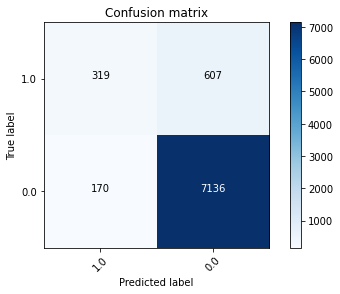

In [51]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy - Logistic Regression

In [52]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9056122448979592


### Saving the model - Logistic Regression

In [74]:
lrModel.save("/content/logmodel")
lr_temp = lrModel.load("/content/logmodel")
lr_temp_pred = lr_temp.transform(test)
lr_temp_pred.show(2)


+---+-------+-------+-----------+-------+-------+-------+--------+-----+-----------+--------+--------+-----+--------+--------+-------------+---+--------+----------+-------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+-----------+---------------+---------------+-----------------+---------------+---------------+-------------+---------------+-------------+-------------------+----------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|age|    job|marital|  education|default|housing|   loan| contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|cons_conf_idx|  y| Age_udf|age_udfidx|job_cat|marital_cat|education_cat|default_cat|housing_cat|loan_cat|contact_cat|month_cat|day_of_week_cat|poutcome_cat|age_encoded|    job_encoded|marital_encoded|education_encoded|default_encoded|housing_encoded| loan_encoded|contact_encoded|month_encoded|day_of_week_encoded|p

# Model Training - Random Forest

In [53]:
df_model = df.select(df["features"],df["label"])

In [54]:
df_model.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(51,[0,1,2,4,7,16...|  0.0|
|(51,[0,1,2,4,7,11...|  0.0|
|(51,[0,1,2,4,5,11...|  0.0|
|(51,[0,1,2,4,5,8,...|  0.0|
|(51,[0,1,2,4,7,11...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [55]:
training_df, test_df = df_model.randomSplit([0.8, 0.2], seed = 2018)

In [56]:
from pyspark.ml.classification import RandomForestClassifier

In [57]:
rf_classifier = RandomForestClassifier(labelCol="label",numTrees=50).fit(training_df)

In [58]:
rf_prediction = rf_classifier.transform(test_df)

In [59]:
rf_prediction.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|  0.0|[43.1698059193618...|[0.86339611838723...|       0.0|
|(51,[0,1,2,3,4,5,...|  0.0|[40.5499899142128...|[0.81099979828425...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



### Accuracy- Random Forest

In [60]:
accuracy1 = rf_prediction.filter(rf_prediction.label == rf_prediction.prediction).count() / float(rf_prediction.count())
print("Accuracy : ",accuracy1)

Accuracy :  0.896622934888241


### Saving the model - Random Forest

In [75]:
rf_classifier.save("/content/rforest")
rf_temp = rf_classifier.load("/content/rforest")
rf_temp_pred = rf_temp.transform(test_df)
rf_temp_pred.show(2)


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|  0.0|[43.1698059193618...|[0.86339611838723...|       0.0|
|(51,[0,1,2,3,4,5,...|  0.0|[40.5499899142128...|[0.81099979828425...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



# Model Training - Decision Tree

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier
df_classifier = DecisionTreeClassifier(labelCol="label").fit(training_df)
df_prediction = df_classifier.transform(test_df)
df_prediction.show(2)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|  0.0|[25914.0,936.0]|[0.96513966480446...|       0.0|
|(51,[0,1,2,3,4,5,...|  0.0|  [706.0,146.0]|[0.82863849765258...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 2 rows



### Accuracy - Decision Tree

In [62]:
accuracy2 = df_prediction.filter(df_prediction.label == df_prediction.prediction).count() / float(df_prediction.count())
print("Accuracy : ",accuracy2)

Accuracy :  0.9042759961127308


### Saving the model - Decision Tree

In [69]:
df_classifier.save("/content/dtree")

In [70]:
dt_temp = df_classifier.load("/content/dtree") 

In [71]:
dt_temp_pred = dt_temp.transform(test_df)

In [73]:
dt_temp_pred.show(2)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|  0.0|[25914.0,936.0]|[0.96513966480446...|       0.0|
|(51,[0,1,2,3,4,5,...|  0.0|  [706.0,146.0]|[0.82863849765258...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 2 rows



# Model Training - GBTClassifier

In [63]:
from pyspark.ml.classification import GBTClassifier
gf_classifier = GBTClassifier(labelCol="label",featuresCol="features").fit(training_df)
gf_prediction = gf_classifier.transform(test_df)
gf_prediction.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|  0.0|[0.52247774832195...|[0.73980504015243...|       0.0|
|(51,[0,1,2,3,4,5,...|  0.0|[1.32344973941615...|[0.93381963421326...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



### Accuracy - GBTClassifier

In [64]:
accuracy3 = gf_prediction.filter(gf_prediction.label == gf_prediction.prediction).count() / float(gf_prediction.count())
print("Accuracy : ",accuracy3)

Accuracy :  0.9094995140913509


### Saving the model - GBTClassifier

In [76]:
gf_classifier.save("/content/gbt")
gf_temp = gf_classifier.load("/content/gbt")
gf_temp_pred = gf_temp.transform(test_df)
gf_temp_pred.show(2)


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|  0.0|[0.52247774832195...|[0.73980504015243...|       0.0|
|(51,[0,1,2,3,4,5,...|  0.0|[1.32344973941615...|[0.93381963421326...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [65]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [66]:
kmeans = KMeans(featuresCol='features',k=2)